In [14]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
from tqdm import tqdm

In [15]:
from utils import read_dataset, plot_confusion_matrix
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

# Load passive dataset

In [16]:
passive_trials = read_dataset("passive_trials.h5")

In [17]:
X = []
Y = []

for trial in passive_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

In [18]:
X_train, _, _, _ = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify=Y)

In [19]:
attr_means = X_train.reshape(-1, 16).mean(axis=0)
attr_std = X_train.reshape(-1, 16).std(axis=0)

# Load yoked dataset

In [20]:
yoked_trials = read_dataset("yoked_trials_exp2.h5")

In [21]:
X = []
Y = []

for trial in yoked_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

### Normalising yoked dataset

In [22]:
X_scaled = (X - attr_means) / attr_std

### Creating tensor dataset

In [23]:
X = torch.from_numpy(X_scaled)
Y = torch.from_numpy(Y).type(torch.LongTensor)
yoked_dataset = torch.utils.data.TensorDataset(X, Y)
yoked_loader = torch.utils.data.DataLoader(yoked_dataset, batch_size=32, shuffle=False)

# Load pre-trained model

In [27]:
#model = ComplexRNNModel(16, 12, 6, 3)
# model.load_state_dict(torch.load("force_model2.pt"))
model = RNNModel(16, 8, 1, 3)
# model.load_state_dict(torch.load("mass_model.pt"))
model.eval()

RNNModel(
  (rnn): LSTM(16, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

In [28]:
predicted = []
total = 0
correct = 0

for x, y in yoked_loader:
    x = Variable(x)
    y_hat = model(x)

    prediction = torch.max(y_hat.data, 1)[1]
    
    total += y.size(0)
    correct += (prediction == y).sum()
    predicted.extend(prediction)

accuracy = 100 * correct / float(total)
print(accuracy)

tensor(35)


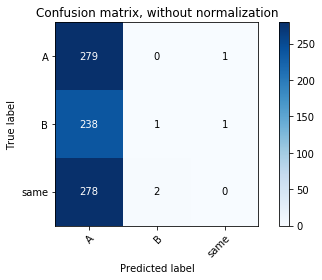

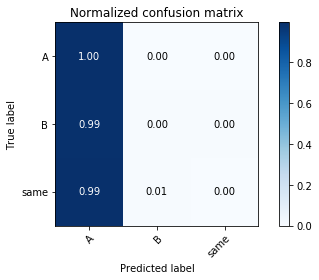

In [29]:
plot_confusion_matrix(Y, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y, predicted, classes=MASS_CLASS_COLS, normalize=True)

# Tune loaded model  

In [30]:
yoked_trials = read_dataset("yoked_trials_exp2.h5")

In [31]:
X = []
Y = []

for trial in yoked_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

In [50]:
X_scaled = (X - attr_means) / attr_std

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state = 42, stratify=Y)

In [33]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)
Y_val = torch.from_numpy(Y_val).type(torch.LongTensor)

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training loop

In [43]:
model = RNNModel(16, 8, 1, 3)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [44]:
epoch_losses = []
epoch_accuracies = []

In [ ]:
num_epochs = 200

for epoch in  tqdm(range(num_epochs)):
    
    epoch_loss = 0
    
    for i, (x, y) in enumerate(train_loader):
        
        x = Variable(x)
        y = Variable(y)
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(x)
            
        # Calculate softmax and ross entropy loss
        loss = error(y_hat, y)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss)
    
    correct = 0
    total = 0

    for x_val, y_val in val_loader:
        x_val = Variable(x_val)
        y_hat = model(x_val)

        predicted = torch.max(y_hat.data, 1)[1]
        
        total += y_val.size(0)
        correct += (predicted == y_val).sum()

    accuracy = 100 * correct / float(total)
    
    epoch_accuracies.append(accuracy)
    
    print(epoch_losses[-1], epoch_accuracies[-1])

  0%|          | 1/200 [00:11<36:40, 11.06s/it]

22.427738428115845 tensor(35)


  1%|          | 2/200 [00:23<37:56, 11.50s/it]

22.341548562049866 tensor(35)


  2%|▏         | 3/200 [00:34<37:14, 11.35s/it]

22.277514219284058 tensor(35)


  2%|▏         | 4/200 [00:46<38:05, 11.66s/it]

22.219202995300293 tensor(35)


  2%|▎         | 5/200 [00:59<38:24, 11.82s/it]

22.165501475334167 tensor(35)


  3%|▎         | 6/200 [01:09<36:55, 11.42s/it]

22.115599393844604 tensor(35)


  4%|▎         | 7/200 [01:22<37:52, 11.78s/it]

22.068822860717773 tensor(35)


  4%|▍         | 8/200 [01:32<36:36, 11.44s/it]

22.02458882331848 tensor(34)


  4%|▍         | 9/200 [01:43<35:47, 11.24s/it]

21.982393860816956 tensor(34)


  5%|▌         | 10/200 [01:55<35:56, 11.35s/it]

21.94178605079651 tensor(33)


  6%|▌         | 11/200 [02:05<35:01, 11.12s/it]

21.902331352233887 tensor(33)


  6%|▌         | 12/200 [02:17<35:22, 11.29s/it]

21.863536834716797 tensor(34)


  6%|▋         | 13/200 [02:29<35:46, 11.48s/it]

21.82480299472809 tensor(33)


  7%|▋         | 14/200 [02:40<35:36, 11.48s/it]

21.78509759902954 tensor(31)


  8%|▊         | 15/200 [02:51<34:54, 11.32s/it]

21.74254012107849 tensor(33)


  8%|▊         | 16/200 [03:02<33:49, 11.03s/it]

21.699179768562317 tensor(32)


  8%|▊         | 17/200 [03:13<33:25, 10.96s/it]

21.65743839740753 tensor(31)


  9%|▉         | 18/200 [03:24<33:55, 11.19s/it]

21.61779546737671 tensor(31)


 10%|▉         | 19/200 [03:35<33:16, 11.03s/it]

21.578782439231873 tensor(33)


 10%|█         | 20/200 [03:47<33:46, 11.26s/it]

21.539377570152283 tensor(34)


 10%|█         | 21/200 [03:59<34:08, 11.45s/it]

21.49924647808075 tensor(35)


 11%|█         | 22/200 [04:10<34:19, 11.57s/it]

21.458221912384033 tensor(35)


 12%|█▏        | 23/200 [04:22<34:20, 11.64s/it]

21.416165709495544 tensor(36)


 12%|█▏        | 24/200 [04:33<33:24, 11.39s/it]

21.372954964637756 tensor(38)


 12%|█▎        | 25/200 [04:44<32:33, 11.16s/it]

21.32846760749817 tensor(39)


 13%|█▎        | 26/200 [04:54<31:53, 10.99s/it]

21.282590866088867 tensor(38)


 14%|█▎        | 27/200 [05:05<31:26, 10.91s/it]

21.235232949256897 tensor(37)


 14%|█▍        | 28/200 [05:16<31:44, 11.07s/it]

21.18631672859192 tensor(37)


 14%|█▍        | 29/200 [05:31<34:04, 11.95s/it]

21.13577651977539 tensor(38)


 15%|█▌        | 30/200 [05:43<34:16, 12.10s/it]

21.08353042602539 tensor(38)


 16%|█▌        | 31/200 [05:55<34:15, 12.16s/it]

21.029352962970734 tensor(38)


 16%|█▌        | 32/200 [06:08<34:34, 12.35s/it]

20.9719677567482 tensor(37)


 16%|█▋        | 33/200 [06:20<33:39, 12.09s/it]

20.912112176418304 tensor(36)


 17%|█▋        | 34/200 [06:31<32:46, 11.84s/it]

20.852340757846832 tensor(36)


 18%|█▊        | 35/200 [06:43<32:36, 11.86s/it]

20.788632929325104 tensor(37)


 18%|█▊        | 36/200 [06:54<32:08, 11.76s/it]

20.723999977111816 tensor(37)


 18%|█▊        | 37/200 [07:05<31:19, 11.53s/it]

20.65764731168747 tensor(36)


 19%|█▉        | 38/200 [07:16<30:39, 11.36s/it]

20.58904469013214 tensor(36)


 20%|█▉        | 39/200 [07:27<30:19, 11.30s/it]

20.517975628376007 tensor(37)


 20%|██        | 40/200 [07:39<30:17, 11.36s/it]

20.444352328777313 tensor(38)


 20%|██        | 41/200 [07:50<29:42, 11.21s/it]

20.368447482585907 tensor(36)


 21%|██        | 42/200 [08:01<29:43, 11.28s/it]

20.30622810125351 tensor(38)


 22%|██▏       | 43/200 [08:12<29:17, 11.20s/it]

20.22816038131714 tensor(38)


 22%|██▏       | 44/200 [08:24<29:30, 11.35s/it]

20.13870072364807 tensor(38)


 22%|██▎       | 45/200 [08:35<29:01, 11.24s/it]

20.05984902381897 tensor(39)


 23%|██▎       | 46/200 [08:46<28:31, 11.12s/it]

19.967300534248352 tensor(40)


 24%|██▎       | 47/200 [08:57<28:21, 11.12s/it]

19.865899860858917 tensor(39)


 24%|██▍       | 48/200 [09:07<27:49, 10.98s/it]

19.79690146446228 tensor(38)


 24%|██▍       | 49/200 [09:19<27:55, 11.10s/it]

19.71042400598526 tensor(38)


 25%|██▌       | 50/200 [09:30<27:35, 11.04s/it]

19.6523979306221 tensor(38)


 26%|██▌       | 51/200 [09:40<27:12, 10.96s/it]

19.560249269008636 tensor(38)


 26%|██▌       | 52/200 [09:52<27:08, 11.01s/it]

19.48700702190399 tensor(38)


 26%|██▋       | 53/200 [10:05<28:25, 11.60s/it]

19.41839724779129 tensor(38)


 27%|██▋       | 54/200 [10:17<28:51, 11.86s/it]

19.360760033130646 tensor(37)


 28%|██▊       | 55/200 [10:29<28:25, 11.76s/it]

19.286225616931915 tensor(37)


 28%|██▊       | 56/200 [10:40<27:59, 11.66s/it]

19.21493023633957 tensor(38)


 28%|██▊       | 57/200 [10:52<27:40, 11.61s/it]

19.191929638385773 tensor(39)


 29%|██▉       | 58/200 [11:03<27:37, 11.68s/it]

19.1829634308815 tensor(38)


 30%|██▉       | 59/200 [11:15<27:44, 11.81s/it]

19.144973635673523 tensor(38)


 30%|███       | 60/200 [11:27<27:28, 11.77s/it]

19.133915841579437 tensor(39)


 30%|███       | 61/200 [11:39<27:18, 11.79s/it]

19.086143016815186 tensor(39)


 31%|███       | 62/200 [11:51<26:59, 11.73s/it]

19.02567332983017 tensor(40)


 32%|███▏      | 63/200 [12:03<27:07, 11.88s/it]

18.960769951343536 tensor(40)


 32%|███▏      | 64/200 [12:15<27:00, 11.92s/it]

18.880293428897858 tensor(40)


 32%|███▎      | 65/200 [12:27<26:41, 11.87s/it]

18.824742078781128 tensor(41)


 33%|███▎      | 66/200 [12:39<26:40, 11.94s/it]

18.770014464855194 tensor(41)


 34%|███▎      | 67/200 [12:52<27:10, 12.26s/it]

18.715846002101898 tensor(40)


 34%|███▍      | 68/200 [13:04<27:00, 12.28s/it]

18.67086547613144 tensor(40)


 34%|███▍      | 69/200 [13:16<26:49, 12.29s/it]

18.60651594400406 tensor(40)


 35%|███▌      | 70/200 [13:28<26:26, 12.20s/it]

18.595032393932343 tensor(40)


 36%|███▌      | 71/200 [13:40<26:12, 12.19s/it]

18.535604238510132 tensor(40)


 36%|███▌      | 72/200 [13:53<25:56, 12.16s/it]

18.50704514980316 tensor(40)


 36%|███▋      | 73/200 [14:05<25:45, 12.17s/it]

18.50442236661911 tensor(40)


 37%|███▋      | 74/200 [14:16<25:15, 12.03s/it]

18.433249175548553 tensor(40)


 38%|███▊      | 75/200 [14:28<24:48, 11.91s/it]

18.377488017082214 tensor(40)


 38%|███▊      | 76/200 [14:39<24:14, 11.73s/it]

18.32871651649475 tensor(40)


 38%|███▊      | 77/200 [14:50<23:36, 11.51s/it]

18.287636160850525 tensor(40)


 39%|███▉      | 78/200 [15:01<23:06, 11.36s/it]

18.238560438156128 tensor(39)


 40%|███▉      | 79/200 [15:13<22:59, 11.40s/it]

18.281945645809174 tensor(38)


 40%|████      | 80/200 [15:28<24:45, 12.38s/it]

18.27853161096573 tensor(39)


 40%|████      | 81/200 [15:40<24:45, 12.48s/it]

18.19884693622589 tensor(39)


 41%|████      | 82/200 [15:53<24:32, 12.48s/it]

18.13870334625244 tensor(38)


 42%|████▏     | 83/200 [16:04<23:38, 12.12s/it]

18.112484097480774 tensor(39)


 42%|████▏     | 84/200 [16:16<23:05, 11.94s/it]

18.010820269584656 tensor(39)


 42%|████▎     | 85/200 [16:27<22:31, 11.75s/it]

18.063973784446716 tensor(38)


 43%|████▎     | 86/200 [16:39<22:21, 11.77s/it]

17.976876854896545 tensor(38)


 44%|████▎     | 87/200 [16:51<22:15, 11.82s/it]

17.970960676670074 tensor(38)


 44%|████▍     | 88/200 [17:02<21:52, 11.72s/it]

17.92959851026535 tensor(37)


 44%|████▍     | 89/200 [17:14<21:42, 11.74s/it]

17.943787157535553 tensor(38)


 45%|████▌     | 90/200 [17:25<21:18, 11.62s/it]

17.928452372550964 tensor(36)


 46%|████▌     | 91/200 [17:38<21:29, 11.83s/it]

17.88037598133087 tensor(36)


 46%|████▌     | 92/200 [17:50<21:25, 11.91s/it]

17.79815948009491 tensor(38)


 46%|████▋     | 93/200 [18:02<21:15, 11.92s/it]

17.823443233966827 tensor(38)


 47%|████▋     | 94/200 [18:14<21:04, 11.93s/it]

17.75061184167862 tensor(38)


 48%|████▊     | 95/200 [18:26<21:01, 12.01s/it]

17.721041679382324 tensor(37)


 48%|████▊     | 96/200 [18:38<20:58, 12.10s/it]

17.81376165151596 tensor(38)


 48%|████▊     | 97/200 [18:51<21:02, 12.26s/it]

17.6931294798851 tensor(36)


 49%|████▉     | 98/200 [19:03<21:03, 12.39s/it]

17.658177196979523 tensor(38)


In [37]:
import matplotlib.pyplot as plt

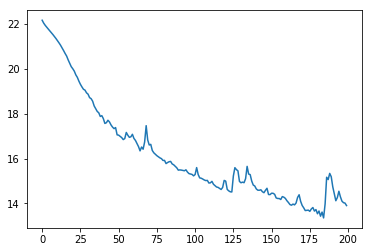

In [38]:
plt.plot(epoch_losses)

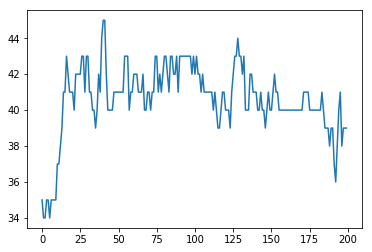

In [39]:
plt.plot(epoch_accuracies)

In [40]:
np.unique(Y, return_counts=True)

(array([0, 1, 2]), array([280, 280, 240]))